#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM = 42

## Подготовка

### Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Изучим информацию о датафрейме

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим на наличие пропусков

In [5]:
total_missing = data.isna().sum()
print(total_missing)

num_orders    0
dtype: int64


Упорядочем данные, проверим на монотонность.

In [6]:
data = data.sort_index()
data.index.is_monotonic

True

Выполним ресемплирование данных по одному часу

In [7]:
data = data.resample('1H').sum() 

Теперь данные подготовлены к анализу

## Анализ

In [8]:
decomposed =  seasonal_decompose(data)

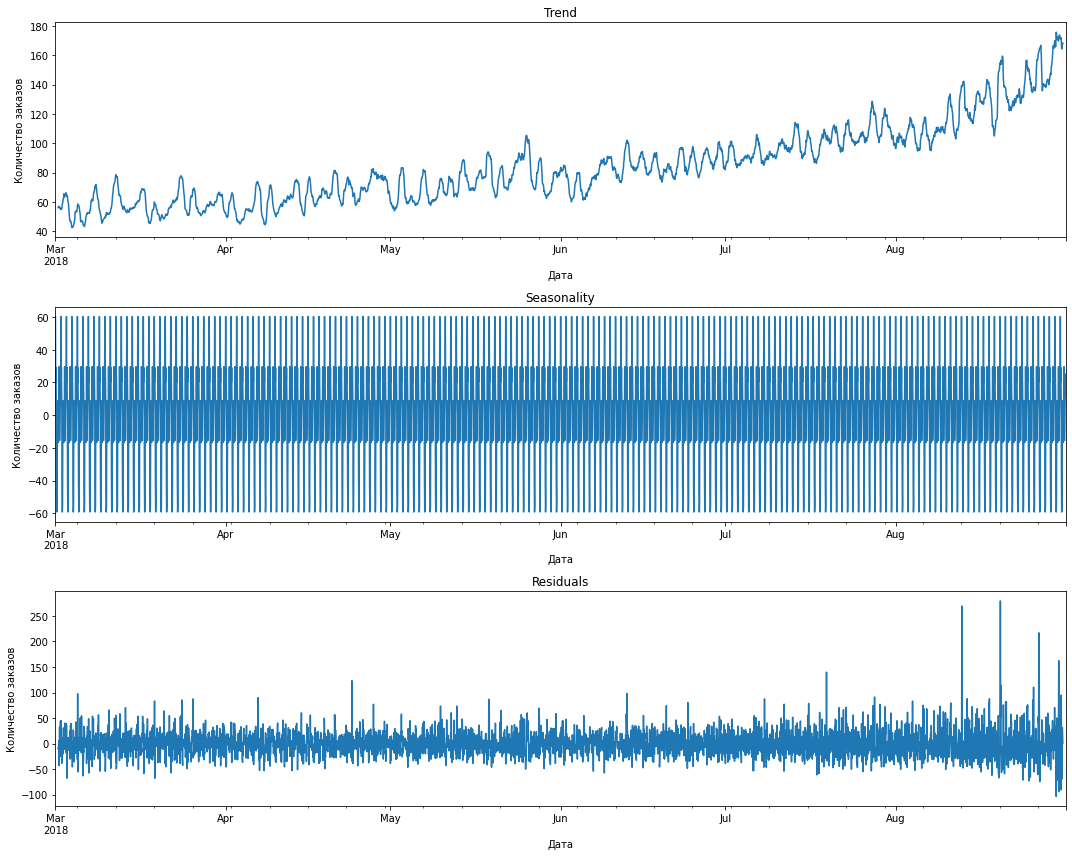

In [9]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.tight_layout()

Можно заметить, что тренд идет на увеличение количества заказов. Более подробно рассмотрим сезонность. 

Text(0, 0.5, 'Количество заказов')

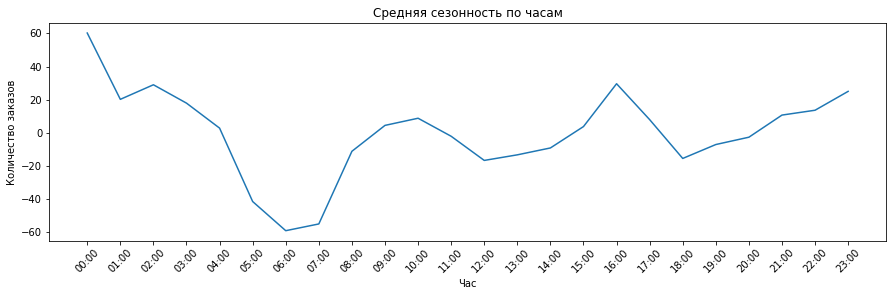

In [10]:
seasonal_hourly = decomposed.seasonal.groupby(decomposed.seasonal.index.hour).mean()

plt.figure(figsize=(15, 4))
seasonal_hourly.plot(ax=plt.gca()) 
plt.xticks(
    ticks=range(24),
    labels=[f'{h:02d}:00' for h in range(24)],
    rotation=45,
    fontsize=10
)
plt.title('Средняя сезонность по часам')
plt.xlabel('Час')
plt.ylabel('Количество заказов')

Можно заметить сезонность по часам. С 6:00 количество заказов начинает увеличиваться до 10:00. Есть пик заказов в 16:00. К полуночи количество возрастает, затем плавно уменьшается. 

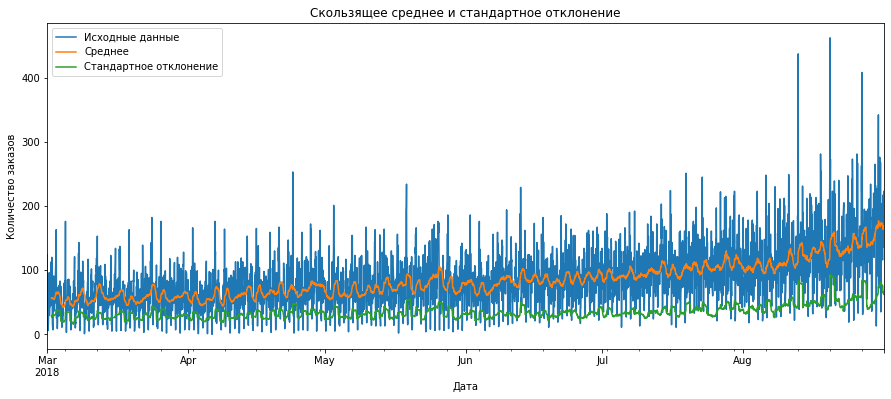

In [11]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()
data['rolling_std'] = data['num_orders'].rolling(24).std()

data[['num_orders', 'rolling_mean', 'rolling_std']].plot(figsize=(15, 6))
plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend(['Исходные данные', 'Среднее', 'Стандартное отклонение'])
plt.show()

Наблюдается устойчивый рост количества заказов с течением времени, что указывает на увеличение спроса на услуги такси в аэропортах. Скользящее среднее подтверждает долгосрочный рост тренда. Стандартное отклонение демонстрирует, что волатильность заказов остается стабильной, без резких всплесков. Это говорит об отсутствии аномальных выбросов. Из анализа сезонности можно выделить пики количества заказов: утренний (6:00–10:00), дневной (16:00), вечерний (20:00–00:00).

## Обучение

### Подготовим данные 

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data 

In [13]:
data.shape

(4416, 3)

In [14]:
data = make_features(data, 1, 4)

In [15]:
data.shape

(4393, 8)

In [16]:
features = data.drop(['num_orders'], axis=1)  
target = data['num_orders']


X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, random_state=RANDOM, test_size=0.1)

cat_features = ['dayofweek', 'hour']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

/tmp/ipykernel_103/4148884626.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
/tmp/ipykernel_103/4148884626.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


### LinearRegression

In [17]:
tscv = TimeSeriesSplit(n_splits=5) 

rmse_scorer = make_scorer(
    lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)
)

model_LR = LinearRegression()
scores = cross_val_score(
    model_LR, 
    X_train_encoded,  
    y_train,    
    cv=tscv,  
    scoring=rmse_scorer
)

print(f"RMSE LinearRegression на кросс-валидации: {scores.mean():.2f} ± {scores.std():.2f}")

#model.fit(X_train_encoded, y_train)
#y_pred_test_LR = model.predict(X_test)
#rmse_test_LR = mean_squared_error(y_test, y_pred_test_LR, squared=False)
#print(f"RMSE на тестовой выборке: {rmse_test_LR:.2f}")

RMSE LinearRegression на кросс-валидации: 25.29 ± 3.14


### RandomForest

In [18]:
param_grid = {
    'n_estimators': np.arange(100, 500, 50), 
    'max_depth': [None, 10, 20, 30],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['sqrt', 'log2', 0.5],   
}

In [19]:
model_RF = RandomForestRegressor(random_state=RANDOM)


tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=model_RF,
    param_distributions=param_grid,
    n_iter=20,                
    cv=tscv,                  
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [20]:
print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 20}


In [21]:
tscv = TimeSeriesSplit(n_splits=3)

best_model = random_search.best_estimator_

scores = cross_val_score(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

print(f"RMSE RandomForest на кросс-валидации: {scores.mean():.2f} ± {scores.std():.2f}")

#best_model.fit(X_train, y_train)
#y_pred_test_RF = best_model.predict(X_test)
#rmse_test_RF = mean_squared_error(y_test, y_pred_test_RF, squared=False)
#print(f"RMSE на тестовой выборке: {rmse_test_RF:.2f}")

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSE RandomForest на кросс-валидации: 27.76 ± 3.50


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


### LightGBM

In [22]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 5
}

In [23]:
model_LighGBM = lgb.LGBMRegressor(**params)

tscv = TimeSeriesSplit(n_splits=3)
cv_scores = cross_val_score(
    model_LighGBM,
    X_train,
    y_train,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    fit_params={'categorical_feature': cat_features}
)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [24]:
cv_rmse = (-cv_scores).mean()
print(f"RMSE  LightGBM на кросс-валидации: {cv_rmse:.2f} ± {(-cv_scores).std():.2f}")


#model.fit(X_train, y_train)
#y_pred_test_LightGBM = model.predict(X_test)
#rmse_test_LightGBM = mean_squared_error(y_test, y_pred_test_LightGBM, squared=False)
#print(f"RMSE на тестовой выборке: {rmse_test_LightGBM:.2f}")

RMSE  LightGBM на кросс-валидации: 26.30 ± 1.32


### CatBoost

In [25]:
model_CatBoost = CatBoostRegressor(
    iterations=500,         
    learning_rate=0.1,     
    depth=6,               
    random_seed=RANDOM,         
    verbose=0               
)

In [26]:
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = cross_val_score(
    model_CatBoost,
    X_train_raw,
    y_train,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [27]:
cv_rmse = (-cv_scores).mean()
print(f"RMSE CatBoost на кросс-валидации: {cv_rmse:.2f} ± {(-cv_scores).std():.2f}")

#model.fit(
#    X_train, 
#    y_train,
#    eval_set=(X_test, y_test),
#    early_stopping_rounds=50,
#    verbose=0
#)

#y_pred_test_CatBoost = model.predict(X_test)
#rmse_test_CatBoost = mean_squared_error(y_test, y_pred_test_CatBoost, squared=False)
#print(f"RMSE на тестовой выборке: {rmse_test_CatBoost:.2f}")

RMSE CatBoost на кросс-валидации: 27.68 ± 3.13


## Тестирование

RMSE LinearRegression на кросс-валидации: 25.29 ± 3.14

RMSE RandomForest на кросс-валидации: 27.78 ± 3.40

RMSE  LightGBM на кросс-валидации: 26.30 ± 1.32

RMSE CatBoost на кросс-валидации: 27.68 ± 3.13

По результатм кросс-валидации лучшей моделью оказалась LinearRegression

In [28]:
model_LR.fit(X_train_encoded, y_train)
y_pred_test_LR = model_LR.predict(X_test_encoded)
rmse_test_LR = mean_squared_error(y_test, y_pred_test_LR, squared=False)
print(f"RMSE на тестовой выборке: {rmse_test_LR:.2f}")

RMSE на тестовой выборке: 43.41


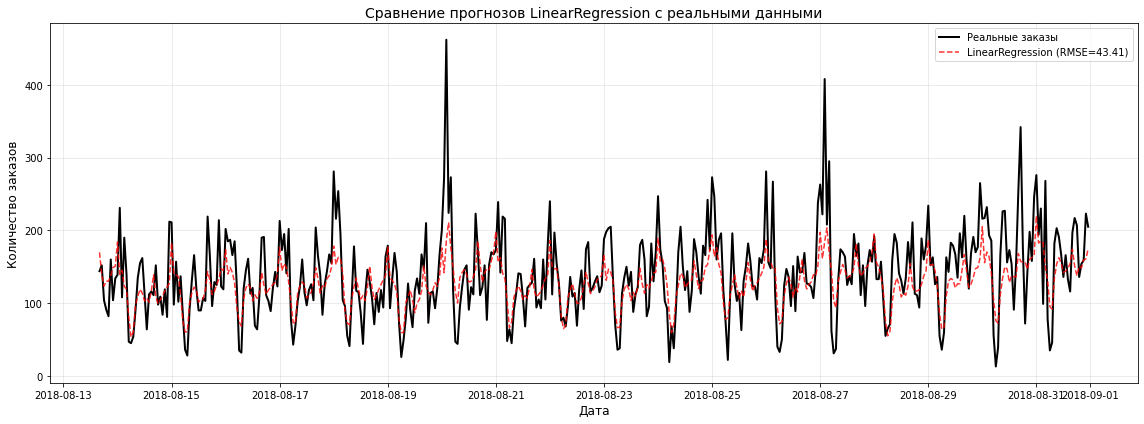

In [29]:
plt.figure(figsize=(16, 6))
plt.title('Сравнение прогнозов LinearRegression с реальными данными', fontsize=14)


sns.lineplot(x=y_test.index, y=y_test, 
             label='Реальные заказы', 
             linewidth=2, 
             color='black')


sns.lineplot(x=y_test.index, y=y_pred_test_LR, 
             label=f'LinearRegression (RMSE={rmse_test_LR:.2f})', 
             linestyle='--', 
             color='red', 
             alpha=0.8)

plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Общий вывод

В ходе анализа было обнаружено, что наблюдается устойчивый рост количества заказов с течением времени, это указывает на увеличение спроса на услуги такси в аэропортах. Скользящее среднее подтверждает долгосрочный рост тренда. Стандартное отклонение демонстрирует, что волатильность заказов остается стабильной, без резких всплесков. Это говорит об отсутствии аномальных выбросов. Из анализа сезонности можно выделить пики количества заказов: утренний (6:00–10:00), дневной (16:00), вечерний (20:00–00:00).

Было обучено и протестировано 4 модели: LinearRegression, RandomForest, LightGBM и CatBoost. Значение метрики RMSE на тестовой выборке должно быть не больше 48. Лучшей моделью оказалась LinearRegression.  RMSE у LinearRegression (43.41).